## Imports, inicializações

In [1]:
!mkdir -p MNIST/trn_img/
!mkdir -p MNIST/trn_lab/
!mkdir -p MNIST/models/crs5/0/
!mkdir -p MNIST/models/crs5/0/


In [ ]:
#!pip install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import collections
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import os
from torchvision import datasets #Import MNIST from torchvision
import torchvision.transforms as transforms
print(torch.version.cuda) #10.1
t3 = time.time()

11.3


In [3]:
##############################################################################
"""args for AE"""

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 1#3    # number of channels in the input data 

args['n_z'] = 300 #600     # number of dimensions in latent space. 

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 10       # how many epochs to run for
args['batch_size'] = 100   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from

args['dataset'] = 'mnist'  #'fmnist' # specify which dataset to use


## Classes Encoder e Decoder

In [ ]:
##############################################################################


## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            
            #3d and 32 by 32
            #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),
            
            nn.BatchNorm2d(self.dim_h * 8), # 40 X 8 = 320
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True) )#,
            #nn.Conv2d(self.dim_h * 8, 1, 2, 1, 0, bias=False))
            #nn.Conv2d(self.dim_h * 8, 1, 4, 1, 0, bias=False))
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        

    def forward(self, x):
        #print('enc')
        #print('input ',x.size()) #torch.Size([100, 3,32,32])
        x = self.conv(x)
        
        x = x.squeeze()
        #print('aft squeeze ',x.size()) #torch.Size([128, 320])
        #aft squeeze  torch.Size([100, 320])
        x = self.fc(x)
        #print('out ',x.size()) #torch.Size([128, 20])
        #out  torch.Size([100, 300])
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            #nn.Sigmoid())
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        #print('input ',x.size())
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False









## SMOTE

In [ ]:
##############################################################################
"""functions to create SMOTE images"""

def biased_get_class(c):
    
    xbeg = dec_x[dec_y == c]
    ybeg = dec_y[dec_y == c]
    
    return xbeg, ybeg
    #return xclass, yclass


def G_SM(X, y,n_to_sample,cl):

    # determining the number of samples to generate
    #n_to_sample = 10 

    # fitting the model
    n_neigh = 5 + 1
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#xsamp, ysamp = SM(xclass,yclass)

In [ ]:
###############################################################################


#NOTE: Download the training ('.../0_trn_img.txt') and label files 
# ('.../0_trn_lab.txt').  Place the files in directories (e.g., ../MNIST/trn_img/
# and /MNIST/trn_lab/).  Originally, when the code was written, it was for 5 fold
#cross validation and hence there were 5 files in each of the 
#directories.  Here, for illustration, we use only 1 training and 1 label
#file (e.g., '.../0_trn_img.txt' and '.../0_trn_lab.txt').

## transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(size=(28,28))])

MNISTtorch = datasets.MNIST(root='./', train=True, download=True, transform=transform)
!mkdir MNIST/trn_img/
!mkdir MNIST/trn_lab/
!mkdir -p MNIST/models/crs5/0/
!mkdir -p MNIST/models/crs5/0/
!mv MNIST/raw/train-images-idx3-ubyte MNIST/trn_img/0_trn_img.txt
!mv MNIST/raw/train-labels-idx1-ubyte MNIST/trn_lab/0_trn_lab.txt
dtrnimg = 'MNIST/trn_img/'
dtrnlab = 'MNIST/trn_lab/'

## download and load training dataset
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
#                                          shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

mkdir: cannot create directory ‘MNIST/trn_img/’: File exists
mkdir: cannot create directory ‘MNIST/trn_lab/’: File exists


In [ ]:
MNISTtorch.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

## Treinamento do Encoder/Decoder - Main

In [ ]:
%%time
ids = os.listdir(dtrnimg)
idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
print(idtri_f)

ids = os.listdir(dtrnlab)
idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
print(idtrl_f)

#for i in range(5):
for i in range(len(ids)):
    print()
    print(i)
    encoder = Encoder(args)
    decoder = Decoder(args)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    train_on_gpu = torch.cuda.is_available()

    #decoder loss function
    criterion = nn.MSELoss()
    criterion = criterion.to(device)
    
#    trnimgfile = idtri_f[i]
#    trnlabfile = idtrl_f[i]
    
#    print(trnimgfile)
#    print(trnlabfile)
#    dec_x = trnimgfile
#    dec_y = trnlabfile

#    dec_x = 
#    dec_y = MNISTtorch.targets
#   print('train imgs before reshape ',dec_x.shape) 
#   print('train labels ',dec_y.shape) 
#   print(collections.Counter(dec_y))
#   dec_x = dec_x.reshape(dec_x.shape[0],1,28,28)   
#   print('train imgs after reshape ',dec_x.shape) 

    dl_batch_size = batch_size=MNISTtorch.__len__()
    batch_size = 128
    num_workers = 0

    #torch.Tensor returns float so if want long then use torch.tensor
 #   tensor_x = dec_x
 #   tensor_y = MNISTtorch.target
 #   mnist_bal = TensorDataset(tensor_x,tensor_y) 
    train_loader = torch.utils.data.DataLoader(MNISTtorch, batch_size=batch_size,shuffle=True,num_workers=num_workers)
    
    ## Carregar dataset na memória
    dl_aux = torch.utils.data.DataLoader(MNISTtorch, batch_size=dl_batch_size,shuffle=True,num_workers=num_workers)
    
    dec_x, dec_y = next(iter(dl_aux))

    del dl_aux

    classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

    best_loss = np.inf

    t0 = time.time()
    if args['train']:
        enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
        dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])
    
        for epoch in range(args['epochs']):
            train_loss = 0.0
            tmse_loss = 0.0
            tdiscr_loss = 0.0
            # train for one epoch -- set nets to train mode
            encoder.train()
            decoder.train()
        
            for images,labs in train_loader:
            
                # zero gradients for each batch
                encoder.zero_grad()
                decoder.zero_grad()
                #print(images)
                images, labs = images.to(device), labs.to(device)
                #print('images ',images.size()) 
                labsn = labs.detach().cpu().numpy()
                #print('labsn ',labsn.shape, labsn)
            
                # run images
                z_hat = encoder(images)
            
                x_hat = decoder(z_hat) #decoder outputs tanh
                #print('xhat ', x_hat.size())
                #print(x_hat)

                #Reconstruction Loss
                mse = criterion(x_hat,images)
                #print('mse ',mse)
                
                       
                resx = []
                resy = []

                #Randomly sample classes            
                tc = np.random.randint(10)
                #tc = 9
                #print("Class:", tc)

                #Randomly sample nsamp instances of that class
                xbeg = dec_x[dec_y == tc]
                ybeg = dec_y[dec_y == tc] 
                xlen = len(xbeg)
                #print("xlen", xlen)
                nsamp = min(xlen, 100)
                ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
                xclass = xbeg[ind]
                yclass = ybeg[ind]
            
                xclen = len(xclass)
                #print('xclen ',xclen)
                xcminus = np.arange(1,xclen)
                #print('minus ',xcminus.shape,xcminus)
                
                xcplus = np.append(xcminus,0)
                #print('xcplus ',xcplus)
                xcnew = (xclass[[xcplus],:])
                #xcnew = np.squeeze(xcnew)
                xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
                #print('xcnew ',xcnew.shape)
            
                xcnew = torch.Tensor(xcnew)
                xcnew = xcnew.to(device)
            
                #Encode xclass to feature space
                xclass = torch.Tensor(xclass)
                xclass = xclass.to(device)
                xclass = encoder(xclass)
                #print('xclass ',xclass.shape) 
            
                xclass = xclass.detach().cpu().numpy()
            
                xc_enc = (xclass[[xcplus],:])
                xc_enc = np.squeeze(xc_enc)
                #print('xc enc ',xc_enc.shape)
            
                xc_enc = torch.Tensor(xc_enc)
                xc_enc = xc_enc.to(device)

                #Decode
                ximg = decoder(xc_enc)
                
                #Penalty Loss 
                mse2 = criterion(ximg,xcnew)
            
                comb_loss = mse2 + mse
                comb_loss.backward()
            
                enc_optim.step()
                dec_optim.step()
            
                train_loss += comb_loss.item()*images.size(0)
                tmse_loss += mse.item()*images.size(0)
                tdiscr_loss += mse2.item()*images.size(0)
            
                 
            # print avg training statistics 
            train_loss = train_loss/len(train_loader)
            tmse_loss = tmse_loss/len(train_loader)
            tdiscr_loss = tdiscr_loss/len(train_loader)
            print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
                    train_loss,tmse_loss,tdiscr_loss))
            
        
#########################5 Way Cross Validation#################################       
           #store the best encoder and decoder models
            #here, /crs5 is a reference to 5 way cross validation, but is not
            #necessary for illustration purposes
            if train_loss < best_loss:
                print('Saving..')
                path_enc = 'MNIST/models/crs5/' \
                    + str(i) + '/bst_enc.pth'
                path_dec = 'MNIST/models/crs5/' \
                    + str(i) + '/bst_dec.pth'
             
                torch.save(encoder.state_dict(), path_enc)
                torch.save(decoder.state_dict(), path_dec)
        
                best_loss = train_loss
################################################################################        
        
        #in addition, store the final model (may not be the best) for
        #informational purposes
        path_enc = 'MNIST/models/crs5/' \
            + str(i) + '/f_enc.pth'
        path_dec = 'MNIST/models/crs5/' \
            + str(i) + '/f_dec.pth'
        print(path_enc)
        print(path_dec)
        torch.save(encoder.state_dict(), path_enc)
        torch.save(decoder.state_dict(), path_dec)
        print()
              
    t1 = time.time()
    print('total time(min): {:.2f}'.format((t1 - t0)/60))             
 
t4 = time.time()
print('final time(min): {:.2f}'.format((t4 - t3)/60))

['MNIST/trn_img/0_trn_img.txt']
['MNIST/trn_lab/0_trn_lab.txt']

0
cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Epoch: 0 	Train Loss: 10.732606 	mse loss: 4.762733 	mse2 loss: 5.969873
Saving..
Epoch: 1 	Train Loss: 2.780352 	mse loss: 1.213597 	mse2 loss: 1.566756
Saving..
Epoch: 2 	Train Loss: 1.898174 	mse loss: 0.830919 	mse2 loss: 1.067256
Saving..
Epoch: 3 	Train Loss: 1.456541 	mse loss: 0.651429 	mse2 loss: 0.805112
Saving..
Epoch: 4 	Train Loss: 1.246277 	mse loss: 0.553843 	mse2 loss: 0.692435
Saving..
Epoch: 5 	Train Loss: 1.062458 	mse loss: 0.479703 	mse2 loss: 0.582754
Saving..
Epoch: 6 	Train Loss: 0.959108 	mse loss: 0.435181 	mse2 loss: 0.523928
Saving..
Epoch: 7 	Train Loss: 0.880734 	mse loss: 0.400463 	mse2 loss: 0.480271
Saving..
Epoch: 8 	Train Loss: 0.820212 	mse loss: 0.374041 	mse2 loss: 0.446170
Saving..
Epoch: 9 	Train Loss: 0.768013 	mse loss: 0.350168 	mse2 loss: 0.417845
Saving..
MNIST/models/crs5/0/f_enc.pth
MNIST/models/crs5/0/f_dec.pth

total time(min): 7.71
final time(min): 8.14


## Generate Samples

In [ ]:
##############################################################################

def biased_get_class1(c):
    
    xbeg = dec_x[dec_y == c]
    ybeg = dec_y[dec_y == c]
    
    return xbeg, ybeg
    #return xclass, yclass


def G_SM1(X, y,n_to_sample,cl):

    
    # fitting the model
    n_neigh = 5 + 1
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#############################################################################



In [ ]:
!mkdir MNIST/trn_img_f/

In [ ]:
!mkdir MNIST/trn_lab_f/

In [ ]:
!ls

MNIST  sample_data


In [ ]:
np.printoptions(precision=5,suppress=True)
%%time
'''
dtrnimg = '.../0_trn_img.txt'
dtrnlab = '.../0_trn_lab.txt'

ids = os.listdir(dtrnimg)
idtri_f = [os.path.join(dtrnimg, image_id) for image_id in ids]
print(idtri_f)

ids = os.listdir(dtrnlab)
idtrl_f = [os.path.join(dtrnlab, image_id) for image_id in ids]
print(idtrl_f)
'''
#path on the computer where the models are stored
modpth = './MNIST/models/crs5/'

encf = []
decf = []
for p in range(5):
    enc = modpth + '/' + str(p) + '/bst_enc.pth'
    dec = modpth + '/' + str(p) + '/bst_dec.pth'
    encf.append(enc)
    decf.append(dec)
    #print(enc)
    #print(dec)
    #print()

for m in range(1):
    print(m)
    '''
    trnimgfile = idtri_f[m]
    trnlabfile = idtrl_f[m]
    print(trnimgfile)
    print(trnlabfile)
    dec_x = np.loadtxt(trnimgfile) 
    dec_y = np.loadtxt(trnlabfile)

    print('train imgs before reshape ',dec_x.shape) #(44993, 3072) 45500, 3072)
    print('train labels ',dec_y.shape) #(44993,) (45500,)

    dec_x = dec_x.reshape(dec_x.shape[0],1,28,28)

    print('decy ',dec_y.shape)
    print(collections.Counter(dec_y))
    
    print('train imgs after reshape ',dec_x.shape) #(45000,3,32,32)
    '''
    dl_batch_size = batch_size=MNISTtorch.__len__()
    batch_size = 128
    num_workers = 0

    #torch.Tensor returns float so if want long then use torch.tensor
 #   tensor_x = dec_x
 #   tensor_y = MNISTtorch.target
 #   mnist_bal = TensorDataset(tensor_x,tensor_y) 
    train_loader = torch.utils.data.DataLoader(MNISTtorch, 
        batch_size=batch_size,shuffle=True,num_workers=num_workers)
    
    ## Carregar dataset na memória
    dl_aux = torch.utils.data.DataLoader(MNISTtorch, 
        batch_size=dl_batch_size,shuffle=True,num_workers=num_workers)
    
    dec_x, dec_y = next(iter(dl_aux))

    del dl_aux

    classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

    best_loss = np.inf

    
    #generate some images 
    train_on_gpu = torch.cuda.is_available()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    path_enc = encf[m]
    path_dec = decf[m]

    encoder = Encoder(args)
    encoder.load_state_dict(torch.load(path_enc), strict=False)
    encoder = encoder.to(device)

    decoder = Decoder(args)
    decoder.load_state_dict(torch.load(path_dec), strict=False)
    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()

    #imbal = [4500, 2000, 1000, 800, 600, 500, 400, 250, 150, 80]
    imbal = [4000, 2000, 1000, 750, 500, 350, 200, 100, 60, 40]

    resx = []
    resy = []

    for i in range(1,10):
        xclass, yclass = biased_get_class1(i)
        print(xclass.shape) #(500, 3, 32, 32)
        print(yclass[0]) #(500,)
            
        #encode xclass to feature space
        xclass = torch.Tensor(xclass)
        xclass = xclass.to(device)
        xclass = encoder(xclass)
        print(xclass.shape) #torch.Size([500, 600])
            
        xclass = xclass.detach().cpu().numpy()
        n = imbal[0] - imbal[i]
        xsamp, ysamp = G_SM1(xclass,yclass,n,i)
        print(xsamp.shape) #(4500, 600)
        print(len(ysamp)) #4500
        ysamp = np.array(ysamp)
        print(ysamp.shape) #4500   
    
        """to generate samples for resnet"""   
        xsamp = torch.Tensor(xsamp)
        xsamp = xsamp.to(device)
        #xsamp = xsamp.view(xsamp.size()[0], xsamp.size()[1], 1, 1)
        #print(xsamp.size()) #torch.Size([10, 600, 1, 1])
        ximg = decoder(xsamp)

        ximn = ximg.detach().cpu().numpy()
        print(ximn.shape) #(4500, 3, 32, 32)
        #ximn = np.expand_dims(ximn,axis=1)
        print(ximn.shape) #(4500, 3, 32, 32)
        resx.append(ximn)
        resy.append(ysamp)
        #print('resx ',resx.shape)
        #print('resy ',resy.shape)
        #print()
    
    resx1 = np.vstack(resx)
    resy1 = np.hstack(resy)
    #print(resx1.shape) #(34720, 3, 32, 32)
    #resx1 = np.squeeze(resx1)
    print(resx1.shape) #(34720, 3, 32, 32)
    print(resy1.shape) #(34720,)

    resx1 = resx1.reshape(resx1.shape[0],-1)
    print(resx1.shape) #(34720, 3072)
    
    dec_x1 = dec_x.reshape(dec_x.shape[0],-1)
    print('decx1 ',dec_x1.shape)
    combx = np.vstack((resx1,dec_x1))
    comby = np.hstack((resy1,dec_y))

    print(combx.shape) #(45000, 3, 32, 32)
    print(comby.shape) #(45000,)

    ifile = './MNIST/trn_img_f/' + \
        str(m) + '_trn_img.txt'
    np.savetxt(ifile, combx)

    
    lfile = './MNIST/trn_lab_f/' + \
        str(m) + '_trn_lab.txt'
    np.savetxt(lfile,comby) 
    print()

t1 = time.time()
print('final time(min): {:.2f}'.format((t1 - t0)/60))

0
torch.Size([6742, 1, 28, 28])
tensor(1)
torch.Size([6742, 300])
(2000, 300)
2000
(2000,)
(2000, 1, 28, 28)
(2000, 1, 28, 28)
torch.Size([5958, 1, 28, 28])
tensor(2)
torch.Size([5958, 300])
(3000, 300)
3000
(3000,)
(3000, 1, 28, 28)
(3000, 1, 28, 28)
torch.Size([6131, 1, 28, 28])
tensor(3)
torch.Size([6131, 300])
(3250, 300)
3250
(3250,)
(3250, 1, 28, 28)
(3250, 1, 28, 28)
torch.Size([5842, 1, 28, 28])
tensor(4)
torch.Size([5842, 300])
(3500, 300)
3500
(3500,)
(3500, 1, 28, 28)
(3500, 1, 28, 28)
torch.Size([5421, 1, 28, 28])
tensor(5)
torch.Size([5421, 300])
(3650, 300)
3650
(3650,)
(3650, 1, 28, 28)
(3650, 1, 28, 28)
torch.Size([5918, 1, 28, 28])
tensor(6)
torch.Size([5918, 300])
(3800, 300)
3800
(3800,)
(3800, 1, 28, 28)
(3800, 1, 28, 28)
torch.Size([6265, 1, 28, 28])
tensor(7)
torch.Size([6265, 300])
(3900, 300)
3900
(3900,)
(3900, 1, 28, 28)
(3900, 1, 28, 28)
torch.Size([5851, 1, 28, 28])
tensor(8)
torch.Size([5851, 300])
(3940, 300)
3940
(3940,)
(3940, 1, 28, 28)
(3940, 1, 28, 28

In [ ]:
for i in range(10):
  print("Classe", i)
  print(combx[comby==i].shape)

Classe 0
(5923, 784)
Classe 1
(8742, 784)
Classe 2
(8958, 784)
Classe 3
(9381, 784)
Classe 4
(9342, 784)
Classe 5
(9071, 784)
Classe 6
(9718, 784)
Classe 7
(10165, 784)
Classe 8
(9791, 784)
Classe 9
(9909, 784)


1


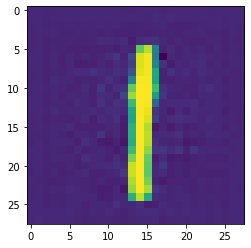

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(combx[0].reshape(28,28))
print(comby[0])

## Resnet

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
#plt.ion()   # interactive mode

In [ ]:
trnimgfile = "/content/MNIST/trn_img_f/0_trn_img.txt"
trnlabfile = "/content/MNIST/trn_lab_f/0_trn_lab.txt"

dec_x = np.loadtxt(trnimgfile) 
dec_y = np.loadtxt(trnlabfile)

print('train imgs before reshape ',dec_x.shape) 
print('train labels ',dec_y.shape) 
print(collections.Counter(dec_y))
dec_x = dec_x.reshape(dec_x.shape[0],1,28,28) 
print('train imgs after reshape ',dec_x.shape) 

tensor_x = torch.Tensor(dec_x)
tensor_y = torch.tensor(dec_y,dtype=torch.long)
mnist_bal = TensorDataset(tensor_x,tensor_y) 
train_loader = torch.utils.data.DataLoader(mnist_bal, batch_size=batch_size,shuffle=True,num_workers=num_workers)

train imgs before reshape  (91000, 784)
train labels  (91000,)
Counter({7.0: 10165, 9.0: 9909, 8.0: 9791, 6.0: 9718, 3.0: 9381, 4.0: 9342, 5.0: 9071, 2.0: 8958, 1.0: 8742, 0.0: 5923})
train imgs after reshape  (91000, 1, 28, 28)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
print(torch.__version__)

1.11.0+cu113


In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = train_loader#torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


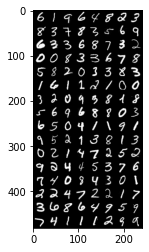

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [ ]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([128, 1, 28, 28])
torch.Size([128, 10])


In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
%%time
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.4716 | Train Accuracy: 397.52
Epoch: 1 | Loss: 1.4704 | Train Accuracy: 397.91
Epoch: 2 | Loss: 1.4691 | Train Accuracy: 398.37
Epoch: 3 | Loss: 1.4688 | Train Accuracy: 398.49
Epoch: 4 | Loss: 1.4684 | Train Accuracy: 398.61
CPU times: user 13.3 s, sys: 228 ms, total: 13.6 s
Wall time: 13.6 s


In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.46
